In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_prominences
from scipy.integrate import simpson

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

In [3]:
names = ['wn'] + [i for i in range(121)]

s1 = pd.read_csv('data/raw/S1_bkg_mapA_11x11.txt', delim_whitespace=True, names=names)
s2 = pd.read_csv('data/raw/S2_bkg_mapA_11x11.txt', delim_whitespace=True, names=names)

In [4]:
s1_intensities = simpson(s1[[i for i in range(121)]].values.T, s1.wn)
s2_intensities = simpson(s2[[i for i in range(121)]].values.T, s2.wn)

# normalization of the spectra
s1[[i for i in range(121)]] = s1[[i for i in range(121)]].div(s1_intensities, axis=1)
s2[[i for i in range(121)]] = s2[[i for i in range(121)]].div(s2_intensities, axis=1)

s1.T.rename(columns=s1.T.loc['wn'].map(int)).loc[0:].to_csv('data/processed/s1.csv', index=False)
s2.T.rename(columns=s2.T.loc['wn'].map(int)).loc[0:].to_csv('data/processed/s2.csv', index=False)

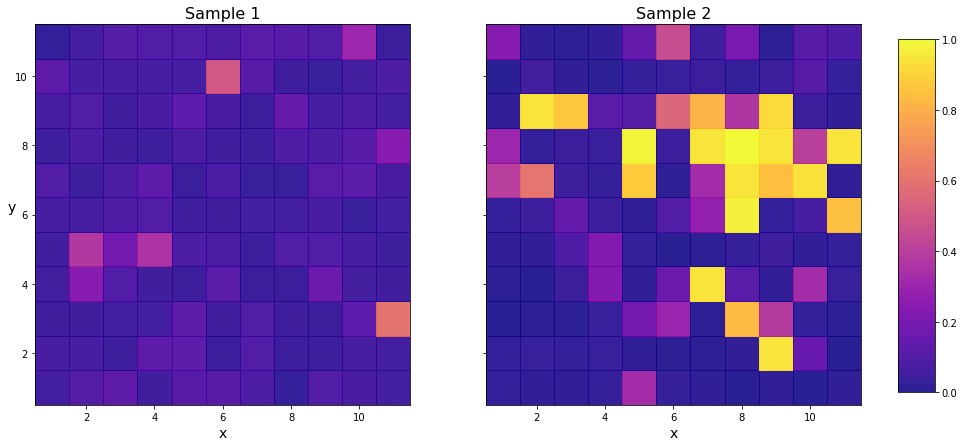

In [5]:
x, y = np.meshgrid(np.arange(1, 12), np.arange(1, 12))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(17, 7))

s1_ints_grid = s1_intensities.reshape(11, 11) / max(max(s1_intensities), max(s2_intensities))
c = ax1.pcolormesh(x, y, s1_ints_grid, vmin=0, vmax=1,
                   cmap='plasma', alpha=0.9, edgecolors='face')

ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('y', fontsize=14, rotation='horizontal')
ax1.set_title('Sample 1', fontsize=16)

s2_ints_grid = s2_intensities.reshape(11, 11) / max(max(s1_intensities), max(s2_intensities))
c = ax2.pcolormesh(x, y, s2_ints_grid, vmin=0, vmax=1,
                   cmap='plasma', alpha=0.9, edgecolors='face')

ax2.set_xlabel('x', fontsize=14)
ax2.set_title('Sample 2', fontsize=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.03, 0.7])
fig.colorbar(c, cax=cbar_ax)

plt.show()

In [6]:
peaks, prominences = [], []
peaks_per_site_s1 = np.zeros((11, 11))
peaks_per_site_s1_w = np.zeros((11, 11))
for i in range(121):
    site_peaks = list(find_peaks(s1[i].values, prominence=0.0005, width=10)[0])
    peaks += site_peaks
    peaks_per_site_s1[i // 11, i % 11] = len(site_peaks)
    prominences += list(peak_prominences(s1[i].values, site_peaks)[0])
    peaks_per_site_s1_w[i // 11, i % 11] = np.sum(peak_prominences(s1[i].values, site_peaks)[0])
    
peaks_per_site_s2 = np.zeros((11, 11))
peaks_per_site_s2_w = np.zeros((11, 11))
for i in range(121):
    site_peaks = list(find_peaks(s2[i].values, prominence=0.0005, width=10)[0])
    peaks += site_peaks
    prominences += list(peak_prominences(s2[i].values, site_peaks)[0])
    peaks_per_site_s2[i // 11, i % 11] = len(site_peaks)
    peaks_per_site_s2_w[i // 11, i % 11] = np.sum(peak_prominences(s2[i].values, site_peaks)[0])

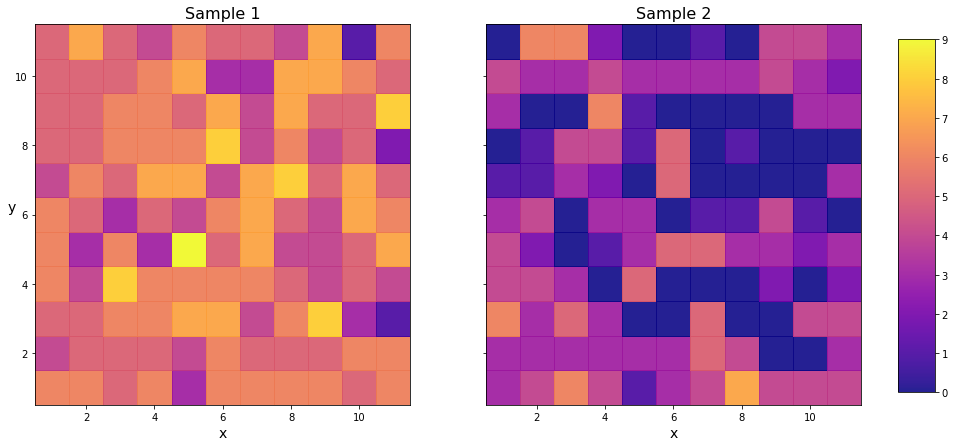

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(17, 7))

max_peaks = max(np.max(peaks_per_site_s1), np.max(peaks_per_site_s2))
c = ax1.pcolormesh(x, y, peaks_per_site_s1, vmin=0, vmax=max_peaks,
                   cmap='plasma', alpha=0.9, edgecolors='face')

ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('y', fontsize=14, rotation='horizontal')
ax1.set_title('Sample 1', fontsize=16)

c = ax2.pcolormesh(x, y, peaks_per_site_s2, vmin=0, vmax=max_peaks,
                   cmap='plasma', alpha=0.9, edgecolors='face')

ax2.set_xlabel('x', fontsize=14)
ax2.set_title('Sample 2', fontsize=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.03, 0.7])
fig.colorbar(c, cax=cbar_ax)

plt.show()

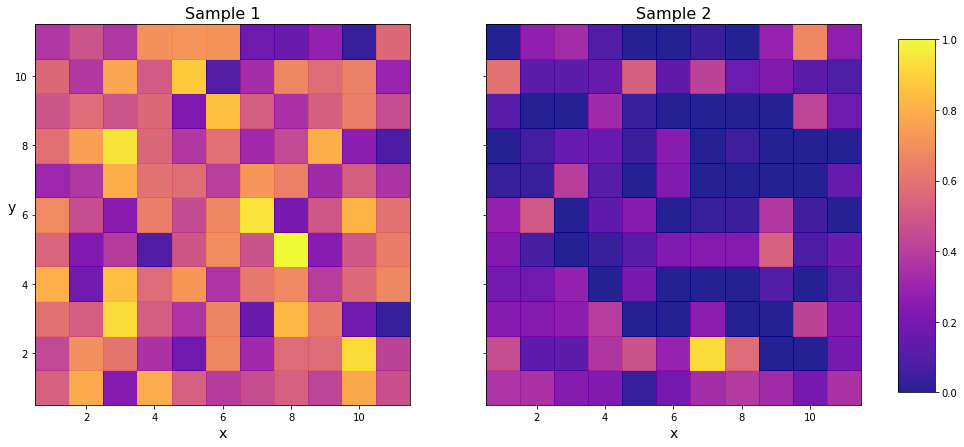

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(17, 7))

max_peaks = max(np.max(peaks_per_site_s1_w), np.max(peaks_per_site_s2_w))
c = ax1.pcolormesh(x, y, peaks_per_site_s1_w / max_peaks, vmin=0, vmax=1,
                   cmap='plasma', alpha=0.9, edgecolors='face')

ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('y', fontsize=14, rotation='horizontal')
ax1.set_title('Sample 1', fontsize=16)

c = ax2.pcolormesh(x, y, peaks_per_site_s2_w / max_peaks, vmin=0, vmax=1,
                   cmap='plasma', alpha=0.9, edgecolors='face')

ax2.set_xlabel('x', fontsize=14)
ax2.set_title('Sample 2', fontsize=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.03, 0.7])
fig.colorbar(c, cax=cbar_ax)

plt.show()

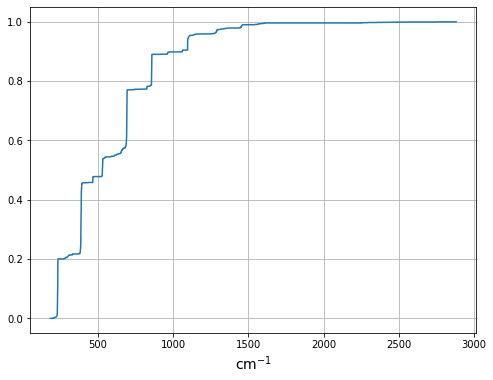

In [9]:
cdf = np.zeros(len(s1.wn))
for peak, prominence in zip(peaks, prominences):
    cdf[peak] += prominence
    
cdf2 = np.zeros(len(s1.wn))
for i, _ in enumerate(cdf):
    cdf2[i] = np.sum(cdf[:i]) / np.sum(cdf)

plt.plot(s1.wn, cdf2)
plt.xlabel('cm$^{-1}$', fontsize=14)

plt.grid()